In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import random
import math
import random
from itertools import product, chain

from glob import glob
from PIL import Image

import numpy as np
import pandas as pd
import cv2
import albumentations as A

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.preprocessing import image
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn import preprocessing, metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer, precision_recall_curve, average_precision_score 

from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, GridSearchCV, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# FL, Decentralized Utilities

In [2]:
def create_data_chunks(data, no_chunks):
    count_per_chunk = data.shape[0] // no_chunks
    return [data[i:i+count_per_chunk] for i in range(0, data.shape[0], count_per_chunk)]

In [3]:
def plot_metrics(x, y, z, title):
    ax = sns.heatmap(
        z, xticklabels=x, yticklabels=y, linewidth=0.5, 
        annot=True, cmap='YlGnBu', square=True
    )
    
    plt.title(title)
    plt.xlabel("No of clients per group")
    plt.ylabel("No of groups")
    plt.show()

In [4]:
def plot_pair_metrics(n, x, y, title, y_axis):
    df = pd.DataFrame({
        'No of groups': x,
        y_axis: y,
        'Clients': n
    })
    if np.mean(y)<1:
        ax = sns.lineplot(
            data=df, x='No of groups', y=y_axis, hue='Clients', estimator=None, linewidth=4
        ).set(title=title)
    else:
        y = np.where(y >=40, 41, y)
        df = pd.DataFrame({
        'No of groups': x,
        y_axis: y,
        'Clients': n
        })
        ax = sns.lineplot(
            data=df, x='No of groups', y=y_axis, hue='Clients', estimator=None, linewidth=4
        ).set(title=title)

    plt.title(title)
    plt.xticks(x)
    plt.legend(loc='lower right', title='Total number of clients')
    plt.show()

In [105]:
# Does a peer's learning work
def model_learn(x, y, model, local_epochs, deep_copy_fn):
    # print(f"Peer: input: x={x.shape}, y={y.shape}")
    x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.2)
    # print(f"Peer: splitting: x_train={x_train.shape}, y_train={y_train.shape}, x_validate={x_validate.shape}, y_validate={y_validate.shape}")   
    
    es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

    model_copy = deep_copy_fn(model)

    model_copy.fit(
        x_train, y_train, epochs = local_epochs, batch_size = 16,  
        validation_data = (x_validate, y_validate), callbacks = [es]
    )
    return model_copy

In [6]:
def pair_wise_post_process(acc, no_grps_list, total_clients, global_rounds, cutoffs):
  accuracy_end = [max(acc[i]) for i in acc]
  plot_pair_metrics([total_clients]*len(no_grps_list), no_grps_list, accuracy_end, f"Accuracy after {global_rounds} rounds", "Accuracy")
  metrics_rounds_85 = np.zeros(len(no_grps_list))
  metrics_rounds_75 = np.zeros(len(no_grps_list))
  for j in cutoffs:
      metrics_rounds_75 = np.zeros(len(no_grps_list))
      for i in range(len(acc)):
            if len(np.argwhere(np.array(acc[i])>=j)) > 0:
              metrics_rounds_75[i] = np.argwhere(np.array(acc[i])>=j)[0][0]
            else:
              metrics_rounds_75[i] = 99
      plot_pair_metrics([total_clients]*len(no_grps_list), no_grps_list, metrics_rounds_75, f"Rounds to reach {j*100}% accuracy", "Rounds")

In [7]:

# Ensemble the models from all peers
def model_weight_ensemble(models, deep_copy_fn):
    # determine how many layers need to be averaged
    n_layers = len(models[0].get_weights())

    # create an set of average model weights
    avg_model_weights = list()
    for layer in range(n_layers):
        # collect this layer from each model
        layer_weights = np.array([model.get_weights()[layer] for model in models])
        # weighted average of weights for this layer
        # avg_layer_weights = np.average(layer_weights, axis=0, weights=weights)
        avg_layer_weights = np.average(layer_weights, axis=0)
        # store average layer weights
        avg_model_weights.append(avg_layer_weights)

    model_copy = deep_copy_fn(models[0])
    model_copy.set_weights(avg_model_weights)
    return model_copy


In [8]:
# Does a master's operation
def master_work(x, y, model, no_peers, local_epochs, deep_copy_fn, sample_value = None):
    # print(f"master input = {len(x)}")

    x_chunks = create_data_chunks(x, no_peers)
    y_chunks = create_data_chunks(y, no_peers)

    client_models = []

    if sample_value == None:
        sample_value = no_peers
    else:
        sample_value = int(sample_value * no_peers)

    sample_value = min(sample_value, 20)

    peers_to_run = random.sample(range(no_peers), sample_value)
    print(peers_to_run)

    for i in peers_to_run:
        print(f"Masterwork: peer={i}")
        client_models.append(model_learn(x_chunks[i], y_chunks[i], deep_copy_fn(model), local_epochs, deep_copy_fn))

    return model_weight_ensemble(client_models, deep_copy_fn)

In [9]:
# The main publisher work
def publisher(x, y, model, no_grps, peers_in_grp, global_rounds, local_epochs, deep_copy_fn, sample_value, random_state=1):
    # print(f"publisher input = {len(x)}")
    x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.2, random_state=random_state) 
    # print(f"Publisher: splitting: x_train={x_train.shape}, y_train={y_train.shape}, x_validate={x_validate.shape}, y_validate={y_validate.shape}")   
    x_groups = create_data_chunks(x_train, no_grps)
    y_groups = create_data_chunks(y_train, no_grps)

    # print(f"Publisher: create groups: x_groups={len(x_groups)}, y_groups={len(y_groups)}")
    global_model = deep_copy_fn(model)
    acc = []
    for r in range(global_rounds):
        print(f"Publisher: global iteration={r}")
        master_models = []
        for i in range(no_grps):
            print(f"Publisher: master={i}")
            # print(f"Publisher: master={i}, x_groups[{i}]={x_groups[i].shape}, y_groups[{i}]={y_groups[i].shape}")
            master_models.append(
                master_work(
                    x_groups[i], y_groups[i], deep_copy_fn(global_model),
                    peers_in_grp, local_epochs, deep_copy_fn, sample_value
                )
            )
        global_model = model_weight_ensemble(master_models, deep_copy_fn)
        y_validate_pred = global_model.predict(x_validate)
        y_validate_pred = np.argmax(y_validate_pred, axis = 1)
        acc.append(round(accuracy_score(y_validate_pred, y_validate), 4))

    print("Publisher: finished all global")
    y_validate_pred = global_model.predict(x_validate)
    y_validate_pred = np.argmax(y_validate_pred, axis = 1)

    final_acc = round(accuracy_score(y_validate_pred, y_validate), 4)
    print("Accuracy on Val Data: ", acc)

    return acc

In [10]:
def get_metrics(acc, cutoffs):
    x = 0
    y = 0

    for i, j in acc:
        x = max(x, i)
        y = max(y, j)
    
    final_acc = np.empty((x+1, y+1))
    max_acc = np.empty((x+1, y+1))
    cutoffs_reached = np.full((len(cutoffs), x+1, y+1), np.NaN)

    for i, j in acc:
        final_acc[i, j] = acc[i, j][-1]
        max_acc[i, j] = max(acc[i, j])

        for r in range(len(acc[i, j])):
            for k in range(len(cutoffs)):
                if np.isnan(cutoffs_reached[k][i, j]) and (acc[i, j][r] >= cutoffs[k]):
                    cutoffs_reached[k][i, j] = int(r)
    
    return final_acc, max_acc, cutoffs_reached

In [11]:
 ## Run full XP
def complete_xp(x, y, model, no_grps_list, peers_in_grp_list, global_rounds, local_epochs, deep_copy_fn, random_state=1, sample_value=None):
    ret = {}

    for i in range(len(peers_in_grp_list)):
        for j in range(len(no_grps_list)):
            print("------------------------------------------------------------------")
            print(f"XP Parameters: peers in grp={peers_in_grp_list[i]}, no groups={no_grps_list[j]}")
            print("------------------------------------------------------------------")
            acc = publisher(
                x, y, model, no_grps_list[j], peers_in_grp_list[i], 
                global_rounds, local_epochs, deep_copy_fn, sample_value,random_state
            )
            ret[i, j] = acc

    return ret

In [12]:
 ## Run pair_wise XP
def pair_wise_xp(x, y, model, no_grps_list, total_clients, global_rounds, local_epochs, deep_copy_fn, random_state=1, sample_value=None):
    ret = {}

    for j in range(len(no_grps_list)):
        number_of_peers_in_group = total_clients // no_grps_list[j]
        print("------------------------------------------------------------------")
        print(f"XP Parameters: peers in grp={number_of_peers_in_group}, no groups={no_grps_list[j]}")
        print("------------------------------------------------------------------")
        acc = publisher(
            x, y, model, no_grps_list[j], number_of_peers_in_group, 
            global_rounds, local_epochs, deep_copy_fn, sample_value, random_state
        )

        ret[j] = acc

    return ret

In [13]:
def plot_accuracy_curves(history, no_grps_list, total_clients):
  rounds = [i+1 for i in range(len(list(history.values())[0]))]
  idx = 0
  fig, ax = plt.subplots(1,figsize=(10,5))
  for combination in history:
    ax.plot(rounds, history[combination], label = str(total_clients[idx]))
    plt.xticks(rounds)
    idx+=1
  plt.legend(*[*zip(*{l:h for h,l in zip(*ax.get_legend_handles_labels())}.items())][::-1]).set_title("Total Peer Groups")
  plt.ylabel("Accuracy")
  plt.xlabel("Global Rounds")
  plt.title("Accuracy Curve for " + str(total_clients) + " clients")
  plt.show()

In [14]:
def plot_accuracy_curves_cfl(history, total_clients):
  rounds = [i+1 for i in range(len(list(history.values())[0]))]
  idx = 0
  fig, ax = plt.subplots(1,figsize=(10,5))
  for combination in history:
    ax.plot(rounds, history[combination], label = str(total_clients[idx]))
    plt.xticks(rounds)
    idx+=1
  plt.legend(*[*zip(*{l:h for h,l in zip(*ax.get_legend_handles_labels())}.items())][::-1]).set_title("Clients")
  plt.ylabel("Accuracy")
  plt.xlabel("Global Rounds")
  plt.title("Accuracy Curve for Centralized FL")
  plt.show()

In [15]:
def plot_accuracy_curves_xp(history, no_grps_list, no_peers_list):
  rounds = [i+1 for i in range(len(list(history.values())[0]))]
  idx = 0
  fig, ax = plt.subplots(1,figsize=(10,5))
  for combination in history:
    ax.plot(rounds, history[combination], label = str(no_grps_list[idx]) + " groups, " + str(no_peers_list[idx]) + " peers/group ")
    plt.xticks(rounds)
    idx+=1
  plt.legend(*[*zip(*{l:h for h,l in zip(*ax.get_legend_handles_labels())}.items())][::-1]).set_title("Peer and Groups")
  plt.ylabel("Accuracy")
  plt.xlabel("Global Rounds")
  plt.title("Accuracy Curve")
  plt.show()

# COVID Radiography Dataset

In [61]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download tawsifurrahman/covid19-radiography-database
! unzip covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

In [62]:
def read_covid_data():
    levels = ['Normal', 'COVID']
    path = "./COVID-19_Radiography_Dataset/"
    data_dir = os.path.join(path)

    data = []
    for id, level in enumerate(levels):
        for file in os.listdir(os.path.join(data_dir , level+ '/images/')):
            data.append(['{}/images/{}'.format(level, file), level])

    data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])

    data['path'] = path + '/' + data['image_file']
    data['corona_result'] = data['corona_result'].map({'Normal': 'Negative', 'COVID': 'Positive'})

    x = []
    y = []

    # Storing images and their labels into a list for further Train Test split

    for i in range(len(data)):
        image = cv2.imread(data['path'][i])
        image = cv2.resize(image, (70, 70)) / 255.0

        label = 1 if data['corona_result'][i] == "Positive" else 0

        x.append(image)
        y.append(label)
    
    return np.array(x), np.array(y)

In [63]:
def get_covid_model():
    model = models.Sequential()
    model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = (70, 70, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(units = 16, activation = 'relu'))
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(units = 2))
    
    model.compile(
        optimizer = 'adam', 
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        metrics = ['accuracy']
    )

    es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
    model.summary()
    return model

In [64]:
def deep_copy_covid_model(model):
    model_copy= keras.models.clone_model(model)
    model_copy.compile(
        optimizer='adam', 
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        metrics = ['accuracy']
    )
    model_copy.set_weights(model.get_weights())
    return model_copy

In [65]:
x_covid, y_covid = read_covid_data()
print(x_covid.shape)
print(y_covid.shape)

(13808, 70, 70, 3)
(13808,)


In [110]:
# Centralized
covid_model = get_covid_model()
covid_model = model_learn(x_covid, y_covid, covid_model, 40, deep_copy_covid_model)

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 68, 68, 128)       3584      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 dropout_25 (Dropout)        (None, 34, 34, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_26 (Dropout)        (None, 16, 16, 64)      

In [ ]:
# Decentralized FL
acc_dfl_covid = complete_xp(np.copy(x_covid), np.copy(y_covid), get_covid_model(), [2,4,8], [3,6,9], 50, 3, deep_copy_covid_model)

In [ ]:
tmp = get_metrics(acc_dfl_covid, [0.85, 0.90])
plot_metrics([2, 3], [2, 3, 4], tmp[0], "Final Accuracy")
plot_metrics([2, 3], [2, 3, 4], tmp[1], "Max Accuracy")
plot_metrics([2, 3], [2, 3, 4], tmp[2][0], "Rounds to 85%")
plot_metrics([2, 3], [2, 3, 4], tmp[2][1], "Rounds to 90%")

In [ ]:
acc_pdfl_covid = pair_wise_xp(np.copy(x_covid), np.copy(y_covid), get_covid_model(), [1, 2, 3, 4, 6, 9, 12, 18], 36, 40, 3, deep_copy_covid_model)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 76ms/step - loss: 1.2793 - accuracy: 0.6364 - val_loss: 0.6395 - val_accuracy: 0.7097
Epoch 3/3
1/1 [==============================] - 0s 79ms/step - loss: 0.6494 - accuracy: 0.6364 - val_loss: 0.6929 - val_accuracy: 0.5161
Publisher: master=12
Epoch 1/3
1/1 [==============================] - 1s 715ms/step - loss: 0.6610 - accuracy: 0.6667 - val_loss: 0.8286 - val_accuracy: 0.7419
Epoch 2/3
1/1 [==============================] - 0s 72ms/step - loss: 1.4508 - accuracy: 0.6992 - val_loss: 0.5897 - val_accuracy: 0.7419
Epoch 3/3
1/1 [==============================] - 0s 72ms/step - loss: 0.6508 - accuracy: 0.6992 - val_loss: 0.6756 - val_accuracy: 0.7419
Publisher: master=13
Epoch 1/3
1/1 [==============================] - 1s 705ms/step - loss: 0.6819 - accuracy: 0.6098 - val_loss: 0.9083 - val_accuracy: 0.6129
Epoch 2/3
1/1 [==============================] - 0s 76ms/step - loss: 1.3301 - accuracy

{0: [0.7476, 0.7476, 0.7476, 0.7476, 0.7476, 0.7476, 0.7476, 0.8353, 0.865, 0.8704, 0.8497, 0.8729, 0.8718, 0.8878, 0.8849, 0.8899, 0.8968, 0.8983, 0.9088, 0.9084, 0.9135, 0.9214, 0.92, 0.92, 0.9265, 0.9207, 0.9272, 0.9283, 0.9229, 0.9283, 0.9272, 0.9312, 0.9359, 0.928, 0.9377, 0.9348, 0.9395, 0.9348, 0.9341, 0.9399], 1: [0.7433, 0.7433, 0.7433, 0.7433, 0.7433, 0.7433, 0.7433, 0.7433, 0.8298, 0.8335, 0.8215, 0.8244, 0.8009, 0.8385, 0.844, 0.8577, 0.8682, 0.8664, 0.8733, 0.8831, 0.8537, 0.8827, 0.8653, 0.882, 0.8755, 0.8932, 0.8689, 0.8943, 0.8888, 0.9048, 0.8961, 0.9012, 0.8986, 0.9131, 0.9084, 0.9084, 0.9109, 0.9167, 0.895, 0.8736], 2: [0.7364, 0.7364, 0.7364, 0.7364, 0.7364, 0.7364, 0.7364, 0.7364, 0.7364, 0.7364, 0.7364, 0.7364, 0.7364, 0.8009, 0.7672, 0.8085, 0.7936, 0.8389, 0.8168, 0.8284, 0.8114, 0.8331, 0.8335, 0.8302, 0.8519, 0.8483, 0.8577, 0.8559, 0.865, 0.7994, 0.8635, 0.8447, 0.8726, 0.8367, 0.8635, 0.8671, 0.8758, 0.8682, 0.8802, 0.8787], 3: [0.7332, 0.7332, 0.7332, 0.7332

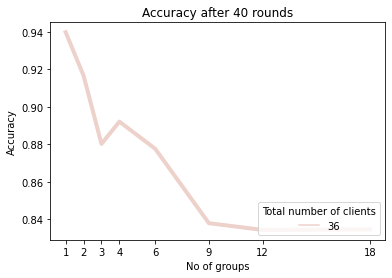

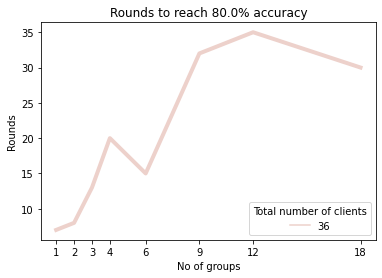

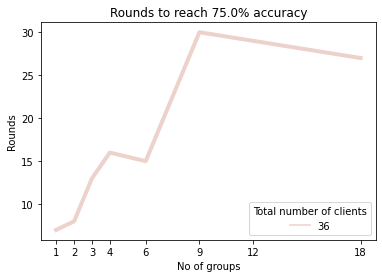

In [ ]:
print(acc_pdfl_covid)
np.save("acc_pdfl_covid.npy",acc_pdfl_covid)
pair_wise_post_process(acc_pdfl_covid,  [1, 2, 3, 4, 6, 9, 12, 18], 36, 40, [0.80, 0.75])

In [ ]:
results = []
for i in [500, 1000]:
    result = pair_wise_xp(np.copy(x_covid), np.copy(y_covid), get_covid_model(), [1, 2, 5, 10], i, 40, 3, deep_copy_covid_model, sample_value=0.1, random_state=1)
    np.save(f"{i}.npy", result)
    results.append(result)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 32ms/step - loss: 0.6335 - accuracy: 0.7500 - val_loss: 0.6968 - val_accuracy: 0.3333
Epoch 3/3
1/1 [==============================] - 0s 28ms/step - loss: 0.6747 - accuracy: 0.7500 - val_loss: 0.6970 - val_accuracy: 0.3333
Masterwork: peer=5
Epoch 1/3
1/1 [==============================] - 1s 705ms/step - loss: 0.5509 - accuracy: 0.7500 - val_loss: 0.7027 - val_accuracy: 0.0000e+00
Epoch 2/3
1/1 [==============================] - 0s 38ms/step - loss: 0.5206 - accuracy: 0.7500 - val_loss: 0.6730 - val_accuracy: 1.0000
Epoch 3/3
1/1 [==============================] - 0s 33ms/step - loss: 0.4091 - accuracy: 0.8750 - val_loss: 0.5808 - val_accuracy: 1.0000
Masterwork: peer=29
Epoch 1/3
1/1 [==============================] - 1s 696ms/step - loss: 0.5873 - accuracy: 0.6250 - val_loss: 0.3799 - val_accuracy: 1.0000
Epoch 2/3
1/1 [==============================] - 0s 28ms/step - loss: 0.5424 - accurac

In [ ]:
from google.colab import files
files.download('1000.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.74, 0.7404, 0.79, 0.7683, 0.8038, 0.798, 0.7839, 0.8132, 0.8255, 0.7831, 0.8215, 0.8085]


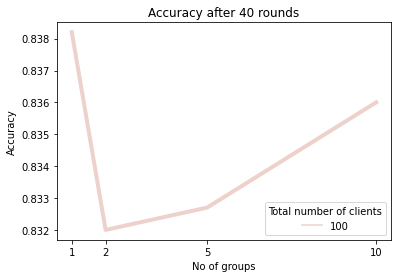

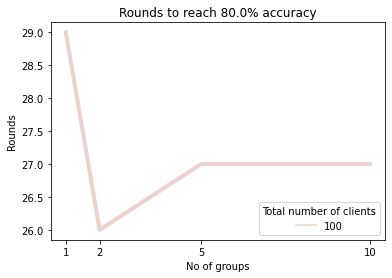

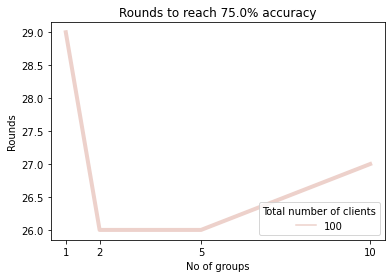

In [ ]:
print(results[0][0])
pair_wise_post_process(results[1],  [1, 2, 5, 10], 100, 40, [0.80, 0.75])

# Fraud Detection Dataset (Not used as data is split 90 to 10, so model only predicts one class)


In [ ]:
! kaggle datasets download rohitrox/healthcare-provider-fraud-detection-analysis
! unzip healthcare-provider-fraud-detection-analysis.zip

In [ ]:
def read_fraud_data():
    def read_data(tp = "Train", N = 1542865627584):
        target = pd.read_csv("./{}-{}.csv".format(tp.title(), N))
        pt = pd.read_csv("./{}_Beneficiarydata-{}.csv".format(tp.title(), N))
        in_pt = pd.read_csv("./{}_Inpatientdata-{}.csv".format(tp.title(), N))
        out_pt = pd.read_csv("./{}_Outpatientdata-{}.csv".format(tp.title(), N))
        return (in_pt, out_pt, pt, target)
    def N_unique_values(df):
        return np.array([len(set([i for i in x[~pd.isnull(x)]])) for x in df.values])
    ### Load data
    in_pt, out_pt, ben, target = read_data()
    ben = ben.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                    'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2,
                    'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2,
                    'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2, 'Gender': 2 }, 
                    0)
    ben = ben.replace({'RenalDiseaseIndicator': 'Y'}, 1).astype({'RenalDiseaseIndicator': 'int64'})
    # Change target variable to binary
    target["target"] = np.where(target.PotentialFraud == "Yes", 1, 0) 
    target.drop('PotentialFraud', axis=1, inplace=True)
    data = pd.merge(in_pt, out_pt,
                    left_on = [ idx for idx in out_pt.columns if idx in in_pt.columns],
                    right_on = [ idx for idx in out_pt.columns if idx in in_pt.columns],
                    how = 'outer').\
          merge(ben,left_on='BeneID',right_on='BeneID',how='inner')
    patient_merge_id = [i for i in out_pt.columns if i in in_pt.columns]
    # Merge in_pt, out_pt and ben df into a single patient dataset
    data = pd.merge(in_pt, out_pt,
                        left_on = patient_merge_id,
                        right_on = patient_merge_id,
                        how = 'outer').\
            merge(ben,left_on='BeneID',right_on='BeneID',how='inner')
    # We find the number of unique physicians 
    data['N_unique_Physicians'] = N_unique_values(data[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']]) 
    # We separate the types of physicians into numeric values
    data[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']] = np.where(data[['AttendingPhysician','OperatingPhysician',
                                                                                        'OtherPhysician']].isnull(), 0, 1)
    # We count the number of types of physicians that attend the patient
    data['N_Types_Physicians'] = data['AttendingPhysician'] +  data['OperatingPhysician'] + data['OtherPhysician']
    # Now we create a variable to check if there is a single doctor on a patient that was attended by more than 1 type of doctor
    # This helps us finds those cases that are only looked at by 1 physicians
    data['Same_Physician'] = data.apply(lambda x: 1 if (x['N_unique_Physicians'] == 1 and x['N_Types_Physicians'] > 1) else 0,axis=1)
    # Similar to Same_Physician, we create a variable to see if 1 physicians has had multiple roles, but has not been alone reviewing the case
    data['Same_Physician2'] = data.apply(lambda x: 1 if (x['N_unique_Physicians'] == 2 and x['N_Types_Physicians'] > 2) else 0,axis=1)
    # We count the number of procedures for each claim, we drop the initial variables
    ClmProcedure_vars = ['ClmProcedureCode_{}'.format(x) for x in range(1,7)]
    data['N_Procedure'] = N_unique_values(data[ClmProcedure_vars])
    data = data.drop(ClmProcedure_vars, axis = 1)
    # We count the number of claims, we also separate this by unique claims and extra claims, we drop the initial variables
    ClmDiagnosisCode_vars =['ClmAdmitDiagnosisCode'] + ['ClmDiagnosisCode_{}'.format(x) for x in range(1, 11)]
    data['N_Unique_Claims'] = N_unique_values(data[ClmDiagnosisCode_vars])
    data['N_Total_Claims'] = data[ClmDiagnosisCode_vars].notnull().to_numpy().sum(axis = 1)
    data['N_Extra_Claims'] = data['N_Total_Claims'] - data['N_Unique_Claims']
    ClmDiagnosisCode_vars.append('N_Total_Claims')
    data = data.drop(ClmDiagnosisCode_vars, axis = 1)
    #  Transform string columns of date into type date
    data['AdmissionDt'] = pd.to_datetime(data['AdmissionDt'] , format = '%Y-%m-%d')
    data['DischargeDt'] = pd.to_datetime(data['DischargeDt'],format = '%Y-%m-%d')
    data['ClaimStartDt'] = pd.to_datetime(data['ClaimStartDt'] , format = '%Y-%m-%d')
    data['ClaimEndDt'] = pd.to_datetime(data['ClaimEndDt'],format = '%Y-%m-%d')
    data['DOB'] = pd.to_datetime(data['DOB'] , format = '%Y-%m-%d')
    data['DOD'] = pd.to_datetime(data['DOD'],format = '%Y-%m-%d')
    # Number of days
    data['Admission_Days'] = ((data['DischargeDt'] - data['AdmissionDt']).dt.days) + 1
    # Number of claim days 
    data['Claim_Days'] = ((data['ClaimEndDt'] - data['ClaimStartDt']).dt.days) + 1
    # Age at the time of claim
    data['Age'] = round(((data['ClaimStartDt'] - data['DOB']).dt.days + 1)/365.25)
    # We create a Hospitalization flag 
    data['Hospt'] = np.where(data.DiagnosisGroupCode.notnull(), 1, 0)
    data = data.drop(['DiagnosisGroupCode'], axis = 1)
    # Variable if patient is dead
    data['Dead']= 0
    data.loc[data.DOD.notna(),'Dead'] = 1
    data['Missing_Deductible_Amount_Paid'] = 0
    data.loc[data['DeductibleAmtPaid'].isnull(), 'Missing_Deductible_Amount_Paid'] = 1 
    data = data.fillna(0).copy()
    _sum = data.groupby(['Provider'], as_index = False)[['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'RenalDiseaseIndicator', 
                                                    'ChronicCond_Alzheimer', 'AttendingPhysician', 'OperatingPhysician', 
                                                    'OtherPhysician', 'N_unique_Physicians', 'ChronicCond_Heartfailure', 
                                                    'N_Types_Physicians', 'Same_Physician',
                                                    'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 
                                                    'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 
                                                    'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 
                                                    'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
                                                    'ChronicCond_stroke', 'Dead', 
                                                    'N_Procedure','N_Unique_Claims', 'N_Extra_Claims', 'Admission_Days',
                                                    'Claim_Days', 'Hospt', 'Missing_Deductible_Amount_Paid']].sum()

    # To separate our variables, we shall add '_sum' at the end of their names
    _sum = _sum.add_suffix('_sum')
    ### Count number of records
    _count = data[['BeneID', 'ClaimID']].groupby(data['Provider']).nunique().reset_index()
    _count.rename(columns={'BeneID':'BeneID_count','ClaimID':'ClaimID_count'},inplace=True)
    ### Calculate mean for all numeric variables
    _mean = data.groupby(['Provider'], as_index = False)[['NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
                                                        'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
                                                        'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Age',
                                                        'AttendingPhysician', 'OperatingPhysician','OtherPhysician',
                                                        'N_unique_Physicians', 'ChronicCond_Heartfailure', 
                                                        'N_Types_Physicians', 'Same_Physician',
                                                        'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 
                                                        'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 
                                                        'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 
                                                        'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
                                                        'ChronicCond_stroke', 'Dead', 'N_Procedure','N_Unique_Claims', 
                                                        'N_Extra_Claims', 'Admission_Days','Claim_Days', 'Hospt',
                                                        'Missing_Deductible_Amount_Paid'
                                                    ]].mean()
    # To separate our variables, we shall add '_mean' at the end of their names
    _mean = _mean.add_suffix('_mean')
    # We create a dataset that holds all the variables
    _total = _count.merge(_sum, how='left',left_on='Provider',right_on='Provider_sum').\
                    merge(_mean, how='left',left_on='Provider',right_on='Provider_mean').\
                    drop(['Provider_sum','Provider_mean'], axis=1).\
                    merge(target, on='Provider', how='left')
    df = _total[['InscClaimAmtReimbursed_sum','N_Extra_Claims_sum','Claim_Days_sum',
             'AttendingPhysician_mean','Missing_Deductible_Amount_Paid_mean','Dead_mean','Claim_Days_mean','N_Extra_Claims_mean',
             'BeneID_count','ClaimID_count',
             'Provider','target']]
    print(df.head(3))
    all_data = df.drop(['Provider'], axis=1)
    x = all_data.drop(['target'], axis=1)
    y = all_data.target
    x = np.array(x)
    y = np.array(y)
    x = np.stack(x,axis=0)
    return x,y


In [ ]:
def get_fraud_model():
    sim_model = models.Sequential()
    sim_model.add(layers.Dense(8, activation='relu', input_dim=10))
    sim_model.add(layers.Dense(4, activation='relu'))
    sim_model.add(layers.Dense(2))


    sim_model.compile(
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        optimizer= optimizers.RMSprop(lr=0.01), metrics=['accuracy']
    )

    es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
    sim_model.summary()
    return sim_model

In [ ]:
from tensorflow.keras import optimizers
def deep_copy_fraud_model(model):
    model_copy= keras.models.clone_model(model)
    model_copy.compile(
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        optimizer=optimizers.RMSprop(lr=0.01), metrics=['accuracy']
    )
    model_copy.set_weights(model.get_weights())
    return model_copy

In [ ]:
x_fraud, y_fraud = read_fraud_data()
print(x_fraud.shape)
print(y_fraud.shape)

   InscClaimAmtReimbursed_sum  N_Extra_Claims_sum  Claim_Days_sum  \
0                      104640                   0              61   
1                      605670                  10             617   
2                       52170                   3             362   

   AttendingPhysician_mean  Missing_Deductible_Amount_Paid_mean  Dead_mean  \
0                      1.0                                  0.0   0.000000   
1                      1.0                                  0.0   0.007576   
2                      1.0                                  0.0   0.006711   

   Claim_Days_mean  N_Extra_Claims_mean  BeneID_count  ClaimID_count  \
0         2.440000             0.000000            24             25   
1         4.674242             0.075758           117            132   
2         2.429530             0.020134           138            149   

   Provider  target  
0  PRV51001       0  
1  PRV51003       1  
2  PRV51004       0  
(5410, 10)
(5410,)


In [ ]:
test2 = complete_xp(np.copy(x_fraud), np.copy(y_fraud), get_fraud_model(), [1], [1], 1, 2, deep_copy_fraud_model,random_state=5)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 8)                 88        
                                                                 
 dense_24 (Dense)            (None, 4)                 36        
                                                                 
 dense_25 (Dense)            (None, 2)                 10        
                                                                 
Total params: 134
Trainable params: 134
Non-trainable params: 0
_________________________________________________________________
------------------------------------------------------------------
XP Parameters: peers in grp=1, no groups=1
------------------------------------------------------------------
Publisher: global iteration=0
Publisher: master=0
Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


14/14 [==============================] - 1s 12ms/step - loss: 10809.1113 - val_loss: 8789.7900
Epoch 2/2
14/14 [==============================] - 0s 4ms/step - loss: 7212.9062 - val_loss: 6464.6558
Publisher: finished all global
Accuracy on Val Data:  [0.098]


In [ ]:
# Centralized FL
acc_fl_fraud = complete_xp(np.copy(x_fraud), np.copy(y_fraud), get_fraud_model(), [1], [6, 12, 18, 24, 36, 48, 72], 10, 3, deep_copy_fraud_model,random_state=5)

1/1 [==============================] - 0s 29ms/step - loss: 0.7311 - accuracy: 0.0694 - val_loss: 0.7111 - val_accuracy: 0.1351
Epoch 1/3
1/1 [==============================] - 1s 588ms/step - loss: 0.7815 - accuracy: 0.0694 - val_loss: 0.7396 - val_accuracy: 0.1622
Epoch 2/3
1/1 [==============================] - 0s 31ms/step - loss: 0.7517 - accuracy: 0.0694 - val_loss: 0.7231 - val_accuracy: 0.1622
Epoch 3/3
1/1 [==============================] - 0s 25ms/step - loss: 0.7311 - accuracy: 0.0694 - val_loss: 0.7098 - val_accuracy: 0.1622
Epoch 1/3
1/1 [==============================] - 1s 1s/step - loss: 0.7751 - accuracy: 0.0972 - val_loss: 0.7467 - val_accuracy: 0.1081
Epoch 2/3
1/1 [==============================] - 0s 31ms/step - loss: 0.7454 - accuracy: 0.0972 - val_loss: 0.7278 - val_accuracy: 0.1081
Epoch 3/3
1/1 [==============================] - 0s 24ms/step - loss: 0.7253 - accuracy: 0.0972 - val_loss: 0.7125 - val_accuracy: 0.1081
Epoch 1/3
1/1 [==============================

KeyboardInterrupt: ignored

In [ ]:
plot_accuracy_curve_cfl(acc_fl_fraud,[6, 12, 18, 24, 36, 48, 72])

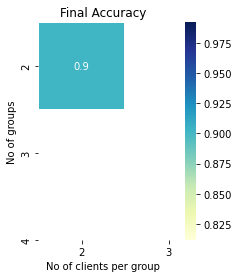

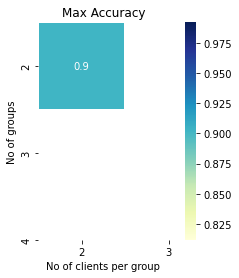

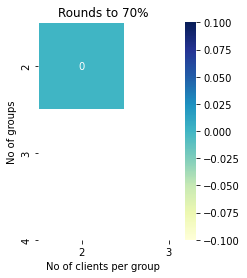

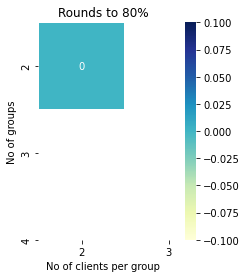

In [ ]:
tmp = get_metrics(acc_fl_fraud, [0.70, 0.8])
plot_metrics([2, 3], [2, 3, 4], tmp[0], "Final Accuracy")
plot_metrics([2, 3], [2, 3, 4], tmp[1], "Max Accuracy")
plot_metrics([2, 3], [2, 3, 4], tmp[2][0], "Rounds to 70%")
plot_metrics([2, 3], [2, 3, 4], tmp[2][1], "Rounds to 80%")

In [ ]:
# Decentralized FL
acc_dfl_fraud = complete_xp(np.copy(x_fraud), np.copy(y_fraud), get_fraud_model(), [2,4,8], [3,6,9], 10, 3, deep_copy_fraud_model)

Streaming output truncated to the last 5000 lines.
Epoch 1/2
1/1 [==============================] - 1s 706ms/step - loss: 0.6251 - accuracy: 0.9375 - val_loss: 0.6380 - val_accuracy: 0.8462
Epoch 2/2
1/1 [==============================] - 0s 51ms/step - loss: 0.6225 - accuracy: 0.9375 - val_loss: 0.6360 - val_accuracy: 0.8462
Epoch 1/2
1/1 [==============================] - 1s 1s/step - loss: 0.6217 - accuracy: 0.9583 - val_loss: 0.6119 - val_accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 35ms/step - loss: 0.6189 - accuracy: 0.9583 - val_loss: 0.6088 - val_accuracy: 1.0000
Epoch 1/2
1/1 [==============================] - 1s 727ms/step - loss: 0.6319 - accuracy: 0.8958 - val_loss: 0.6248 - val_accuracy: 0.9231
Epoch 2/2
1/1 [==============================] - 0s 33ms/step - loss: 0.6295 - accuracy: 0.8958 - val_loss: 0.6223 - val_accuracy: 0.9231
Epoch 1/2
1/1 [==============================] - 1s 730ms/step - loss: 0.6217 - accuracy: 0.9583 - val_loss: 0.6380 - val

ValueError: ignored

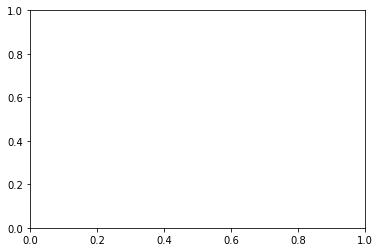

In [ ]:

np.save('acc_df1_fraud', acc_dfl_fraud)
plot_accuracy_curves_xp(acc_dfl_fraud, [2,4,8], [3,6,9])

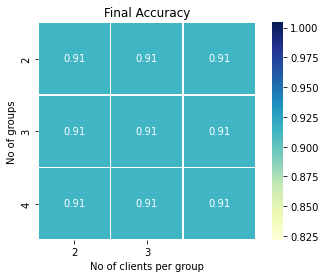

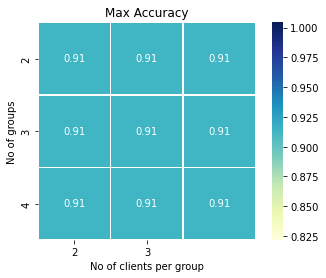

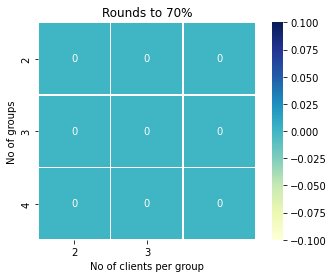

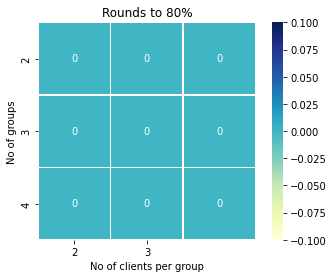

In [ ]:
tmp = get_metrics(acc_dfl_fraud, [0.70, 0.8])
plot_metrics([2, 3], [2, 3, 4], tmp[0], "Final Accuracy")
plot_metrics([2, 3], [2, 3, 4], tmp[1], "Max Accuracy")
plot_metrics([2, 3], [2, 3, 4], tmp[2][0], "Rounds to 70%")
plot_metrics([2, 3], [2, 3, 4], tmp[2][1], "Rounds to 80%")

In [ ]:
acc_pdfl_fraud = pair_wise_xp(np.copy(x_fraud), np.copy(y_fraud), get_fraud_model(), [2, 3, 4, 6, 9, 12, 18], 36, 20, 2, deep_copy_fraud_model)

Streaming output truncated to the last 5000 lines.
Epoch 1/2
1/1 [==============================] - 1s 977ms/step - loss: 0.6501 - accuracy: 0.9231 - val_loss: 0.6501 - val_accuracy: 0.9000
Epoch 2/2
1/1 [==============================] - 0s 43ms/step - loss: 0.6475 - accuracy: 0.9231 - val_loss: 0.6477 - val_accuracy: 0.9000
Epoch 1/2
1/1 [==============================] - 1s 974ms/step - loss: 0.6595 - accuracy: 0.8333 - val_loss: 0.6389 - val_accuracy: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 42ms/step - loss: 0.6575 - accuracy: 0.8333 - val_loss: 0.6359 - val_accuracy: 1.0000
Publisher: master=15
Epoch 1/2
1/1 [==============================] - 1s 983ms/step - loss: 0.6555 - accuracy: 0.8718 - val_loss: 0.6612 - val_accuracy: 0.8000
Epoch 2/2
1/1 [==============================] - 0s 36ms/step - loss: 0.6532 - accuracy: 0.8718 - val_loss: 0.6595 - val_accuracy: 0.8000
Epoch 1/2
1/1 [==============================] - 1s 954ms/step - loss: 0.6555 - accuracy: 0.8718 

In [ ]:
pair_wise_post_process(acc_pdfl_fraud, [2, 3, 4, 6, 9, 12, 18], 36, 40, [0.90, 0.85])

NameError: ignored